https://github.com/Sachin-Jain-98/Detection-And-Classification-Of-Hate-Speech-In-Social-Media-Using-Python/blob/master/Hate_speech_detection_Final_code.ipynb

file:///C:/Users/sumaiyah/Downloads/9%20-Differential%20Tweetment_%20Mitigating%20Racial%20Dialect%20Bias%20in%20Harmful%20Tweet%20Detection.pdf

The tf-idf vectorizer converts a collection of raw documents to a matrix of TF-IDF features.

embed word and character n-grams (contiguous sequences of n items) using either bag-of-words or term frequency-inverse document frequency (TFIDF), which normalizes counts according to the frequency of the n-gram in question in the whole corpus

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms. i.e. the rarer words carry more information

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
# from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_df = pd.read_csv('../data/processed/davison.csv').dropna()
raw_tweets = data_df['tweet']
processed_tweets = data_df['processed_tweet']

In [3]:
#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(processed_tweets)

-----------

In [5]:
X = tfidf
y = data_df['class'].astype(int)

# Baseline ML models

In [6]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)

y_preds_LR_1 = model.predict(X_test_tfidf)
report = classification_report(y_test, y_preds_LR_1)
acc_LR=accuracy_score(y_test,y_preds_LR_1)

print(report)
print("Logistic Regression, Accuracy Score:" , acc_LR)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       809
           1       0.96      0.98      0.97      4147

    accuracy                           0.95      4956
   macro avg       0.92      0.88      0.90      4956
weighted avg       0.95      0.95      0.95      4956

Logistic Regression, Accuracy Score: 0.9469330104923325


In [7]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)

y_preds_NB_1 = nb.predict(X_test_tfidf)
report = classification_report(y_test, y_preds_NB_1)
acc_NB=accuracy_score(y_test,y_preds_NB_1)

print(report)
print("Naive Bayes, Accuracy Score:",acc_NB)

              precision    recall  f1-score   support

           0       0.43      0.75      0.54       809
           1       0.94      0.80      0.87      4147

    accuracy                           0.79      4956
   macro avg       0.68      0.78      0.70      4956
weighted avg       0.86      0.79      0.81      4956

Naive Bayes, Accuracy Score: 0.7941888619854721


In [8]:
support=LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)

y_preds_SVM_1 = support.predict(X_test_tfidf)
acc_SVM=accuracy_score(y_test,y_preds_SVM_1)
report = classification_report(y_test, y_preds_SVM_1)
print(report)
print("SVM, Accuracy Score:" , acc_SVM)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       809
           1       0.97      0.97      0.97      4147

    accuracy                           0.95      4956
   macro avg       0.91      0.92      0.92      4956
weighted avg       0.95      0.95      0.95      4956

SVM, Accuracy Score: 0.9531880548829701


# Sentiment Analysis, using polarity scores as features

In [9]:
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(raw_tweets)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24773,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24774,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24775,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24776,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


In [10]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24778, 6447)

In [11]:
# Running the model Using TFIDF with some features from sentiment analysis
X = pd.DataFrame(modelling_features)
y = data_df['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [14]:
model = LogisticRegression().fit(X_train_bow,y_train)

y_preds_LR_2 = model.predict(X_test_bow)
report = classification_report(y_test, y_preds_LR_2)
acc_LR=accuracy_score(y_test,y_preds_LR_2)

print(report)
print("Logistic Regression,Accuracy Score:" , acc_LR)

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       809
           1       0.96      0.97      0.97      4147

    accuracy                           0.95      4956
   macro avg       0.91      0.89      0.90      4956
weighted avg       0.94      0.95      0.94      4956

Logistic Regression,Accuracy Score: 0.9457223567393059


c:\users\sumaiyah\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
nb=GaussianNB()
nb.fit(X_train_bow,y_train)

y_preds_NB_2 = nb.predict(X_test_bow)
acc_NB=accuracy_score(y_test,y_preds_NB_2)
report = classification_report(y_test, y_preds_NB_2)

print(report)
print("Naive Bayes, Accuracy Score:",acc_NB)

              precision    recall  f1-score   support

           0       0.44      0.75      0.56       809
           1       0.94      0.82      0.88      4147

    accuracy                           0.81      4956
   macro avg       0.69      0.78      0.72      4956
weighted avg       0.86      0.81      0.82      4956

Naive Bayes, Accuracy Score: 0.8056900726392252


In [12]:
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)

y_preds_SVM_2 = support.predict(X_test_bow)
acc_SVM=accuracy_score(y_test,y_preds_SVM_2)
report = classification_report(y_test, y_preds_SVM_2)

print(report)
print("SVM, Accuracy Score:" , acc_SVM)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       809
           1       0.97      0.97      0.97      4147

    accuracy                           0.95      4956
   macro avg       0.91      0.92      0.91      4956
weighted avg       0.95      0.95      0.95      4956

SVM, Accuracy Score: 0.9519774011299436


c:\users\sumaiyah\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [16]:
from scipy.stats import wilcoxon

In [17]:
wilcoxon(y_preds_LR_1, y_preds_LR_2)

WilcoxonResult(statistic=5024.0, pvalue=0.024974679293054237)

In [18]:
wilcoxon(y_preds_NB_1, y_preds_NB_2)

WilcoxonResult(statistic=0.0, pvalue=4.358119027032043e-14)

In [19]:
wilcoxon(y_preds_SVM_1, y_preds_SVM_2)

WilcoxonResult(statistic=823.5, pvalue=0.4385780260809998)

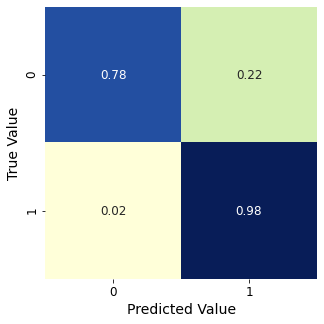

In [29]:
#Confusion Matrix for TFIDF with additional features 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds_LR_1)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['0', '1']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

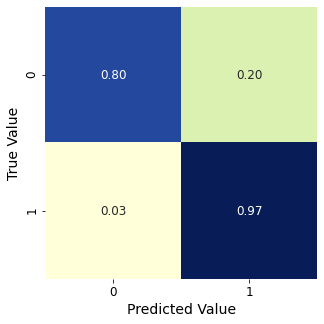

In [30]:
#Confusion Matrix for TFIDF with additional features 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds_LR_2)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['0', '1']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)